# Business Purpose:
The 20 Newsgroups dataset is commonly used for benchmarking text classification models. It serves the purpose of categorizing documents into different topics for applications such as content filtering, recommendation systems, and targeted advertising. A relevant citation can be found at [source].


In [35]:
import re
import os
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords, wordnet
from typing import List, Dict, Tuple
from collections import defaultdict
from sklearn.base import BaseEstimator, clone
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import (
    make_scorer,
    balanced_accuracy_score,
    confusion_matrix,
    accuracy_score,
    classification_report,
)
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [36]:
nltk.data.path.append(f"{os.getcwd()}/nltk_data")
DEFAULT_STOPWORDS = None
NLTK_RESOURCES = ["punkt", "wordnet", "stopwords"]
for resource in NLTK_RESOURCES:
    try:
        nltk.download(resource, download_dir=f"{os.getcwd()}/nltk_data")
        DEFAULT_STOPWORDS = set(stopwords.words("english"))
    except Exception as e:
        print(f"Error downloading {resource}: {e}")

[nltk_data] Downloading package punkt to /home/nick/Documents/ai-
[nltk_data]     nlp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nick/Documents/ai-
[nltk_data]     nlp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nick/Documents/ai-
[nltk_data]     nlp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def preprocess_text(text: str, stop_words: set) -> str:
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    tokens = word_tokenize(text, language="english", preserve_line=True)
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stemmed_tokens = [stemmer.stem(word) for word in lemmatized_tokens]

    return " ".join(stemmed_tokens)

In [38]:
def augment_text_with_wordnet(text: str) -> str:
    tokens = word_tokenize(text, language="english", preserve_line=True)
    augmented_tokens = []
    for token in tokens:
        synsets = wordnet.synsets(token)
        if synsets:
            synonym = synsets[0].lemmas()[0].name()
            augmented_tokens.append(synonym)
        else:
            augmented_tokens.append(token)

    return " ".join(augmented_tokens)

In [39]:
def preprocess_and_augment(text: str, stop_words: set = DEFAULT_STOPWORDS) -> str:
    preprocessed_text = preprocess_text(text, stop_words)
    augmented_text = augment_text_with_wordnet(preprocessed_text)
    return augmented_text

In [40]:
def create_pipeline(model) -> Pipeline:
    return Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(max_features=5000, ngram_range=(1, 2), use_idf=True),
            ),
            ("clf", model),
        ]
    )


def create_bow_pipeline(model) -> Pipeline:
    return Pipeline(
        [
            (
                "bow",
                CountVectorizer(max_features=5000, ngram_range=(1, 2)),
            ),
            ("clf", model),
        ]
    )

In [41]:
def load_dataset(threshold: int = 4) -> tuple:
    newsgroups = fetch_20newsgroups(
        subset="all", categories=None, shuffle=True, random_state=42
    )

    class_names = newsgroups.target_names

    df = pd.DataFrame({"text": newsgroups.data, "label": newsgroups.target})
    df["target_names"] = df["label"].map(
        lambda label: newsgroups.target_names[label]
    )
    class_counts = df["target_names"].value_counts()
    imbalance_ratio = class_counts.max() / class_counts.min()

    print("Distribuição das classes (grupos de notícias):")
    print(class_counts)
    print(f"\nImbalance Ratio (razão de desbalanceamento): {imbalance_ratio:.2f}")

    class_counts.plot(kind="bar", figsize=(10, 6))
    plt.title("Distribuição dos Grupos de Notícias (Classes)")
    plt.xlabel("Grupos de Notícias")
    plt.ylabel("Contagem")
    plt.xticks(rotation=90)
    plt.savefig(f"{os.getcwd()}/class_distribution.png")
    plt.show()
    X_train, X_test, y_train, y_test = train_test_split(
        newsgroups.data, newsgroups.target, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test, class_names, imbalance_ratio <= threshold

In [42]:
def evaluate_models(
    models: Dict[str, Pipeline], X_train: List[str], y_train: List[int],
    is_balanced: bool = False
) -> Dict[str, List[float]]:
    results = {}
    scorer = (
        make_scorer(accuracy_score)
        if is_balanced
        else make_scorer(balanced_accuracy_score)
    )

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer, n_jobs=-1)
        results[model_name] = cv_scores
        print(f"Mean {scorer._score_func.__name__} score: {cv_scores.mean():.4f}\n")
    print()

    return results

In [43]:
def perform_grid_search(
    best_model_pipeline: Pipeline,
    param_grid: Dict[str, List],
    X_train: List[str],
    y_train: List[int],
    is_balanced: bool = False
) -> Pipeline:
    scorer = (
        make_scorer(accuracy_score)
        if is_balanced
        else make_scorer(balanced_accuracy_score)
    )
    grid_search = GridSearchCV(best_model_pipeline, param_grid, scoring=scorer, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best hyperparameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [44]:
def downsample_and_evaluate(
    X: np.ndarray,
    y: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    model: BaseEstimator,
    ratios: List[float] = [0.1, 0.25, 0.5, 0.75, 1.0],
) -> Tuple[List[float], List[float]]:
    scores = []
    for ratio in ratios:
        if ratio == 1.0:
            X_sampled, y_sampled = X, y
        else:
            X_sampled, _, y_sampled, _ = train_test_split(
                X, y, train_size=ratio, stratify=y, random_state=42
            )

        model.fit(X_sampled, y_sampled)

        score = model.score(X_test, y_test)
        scores.append(score)

        print(f"Ratio: {ratio}, Score: {score:.4f}")

    return ratios, scores

In [71]:
def perform_topic_modeling_and_assign_topics(
    X: List[str], num_topics: int = 10
) -> Tuple[np.ndarray, LatentDirichletAllocation]:
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_counts = vectorizer.fit_transform(X)

    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(X_counts)

    topic_assignments = lda_model.transform(X_counts).argmax(axis=1)

    return topic_assignments, lda_model

In [46]:
def train_topic_based_classifiers(
    X: np.ndarray, y: np.ndarray, topics: np.ndarray, classifier: BaseEstimator
) -> Dict[int, BaseEstimator]:
    topic_models = defaultdict()

    for topic in np.unique(topics):
        indices = np.where(topics == topic)[0]

        X_topic = X[indices]
        y_topic = y[indices]

        model_topic = clone(classifier)
        model_topic.fit(X_topic, y_topic)

        topic_models[topic] = model_topic

    return topic_models

In [47]:
def classify_with_topic_model(
    X_new: np.ndarray,
    lda_model: LatentDirichletAllocation,
    topic_models: Dict[int, BaseEstimator],
    vectorizer: CountVectorizer,
) -> np.ndarray:
    X_new_counts = vectorizer.transform(X_new)
    topic_assignments_new = lda_model.transform(X_new_counts).argmax(axis=1)
    predictions = np.array(
        [
            topic_models[topic].predict(X_new_counts[i].reshape(1, -1))[0]
            for i, topic in enumerate(topic_assignments_new)
        ]
    )

    return predictions

In [48]:
def plot_results(results: Dict[str, List[float]], info: str) -> None:
    plt.figure(figsize=(10, 6))
    plt.boxplot(results.values(), labels=results.keys(), showmeans=True)
    plt.title(f"Model Comparison ({info})")
    plt.ylabel("Balanced Accuracy Score")
    plt.xticks(rotation=45)
    plt.savefig(f"{os.getcwd()}/model_comparison_{info}.png")
    plt.show()

In [49]:
def plot_confusion_matrix(
    model: Pipeline, X_test: List[str], y_test: List[int], class_names: List[str]
) -> None:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

Distribuição das classes (grupos de notícias):
target_names
rec.sport.hockey            999
soc.religion.christian      997
rec.motorcycles             996
rec.sport.baseball          994
sci.crypt                   991
rec.autos                   990
sci.med                     990
comp.windows.x              988
sci.space                   987
comp.os.ms-windows.misc     985
sci.electronics             984
comp.sys.ibm.pc.hardware    982
misc.forsale                975
comp.graphics               973
comp.sys.mac.hardware       963
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: count, dtype: int64

Imbalance Ratio (razão de desbalanceamento): 1.59


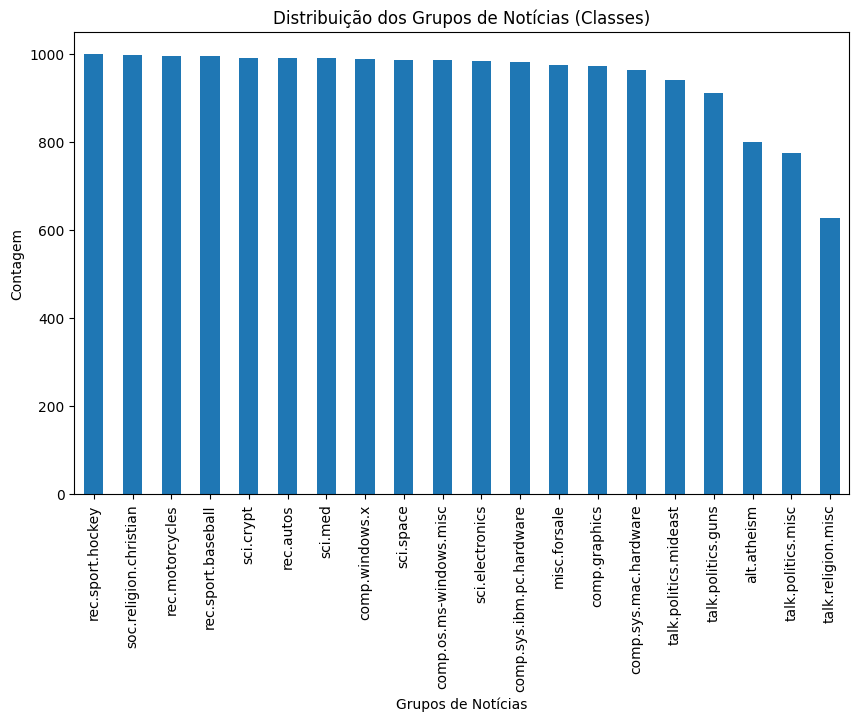

In [50]:
X_train, X_test, y_train, y_test, class_names, is_balanced = load_dataset()

In [51]:
X_train_preprocessed = [preprocess_text(text, DEFAULT_STOPWORDS) for text in X_train]
X_test_preprocessed = [preprocess_text(text, DEFAULT_STOPWORDS) for text in X_test]

X_train_aug_preprocessed = [
    preprocess_and_augment(text, DEFAULT_STOPWORDS) for text in X_train
]
X_test_aug_preprocessed = [
    preprocess_and_augment(text, DEFAULT_STOPWORDS) for text in X_test
]

In [52]:
models = {
    "Naive Bayes": create_pipeline(MultinomialNB()),
    "Logistic Regression": create_pipeline(
        LogisticRegression(max_iter=1000, n_jobs=-1)
    ),
    "SVM": create_pipeline(SVC(kernel="linear")),
    "Random Forest": create_pipeline(RandomForestClassifier(n_jobs=-1)),
    "KNN": create_pipeline(KNeighborsClassifier(n_jobs=-1)),
}

In [53]:
results_per_preprocessing_tfidf = {
    "no_preprocessing_tfidf": evaluate_models(models, X_train, y_train, is_balanced),
    "preprocess_tfidf": evaluate_models(
        models, X_train_preprocessed, y_train, is_balanced
    ),
    "augmentation_and_preprocessing_tfidf": evaluate_models(
        models, X_train_aug_preprocessed, y_train, is_balanced
    ),
}

Evaluating Naive Bayes...
Mean accuracy_score score: 0.7965

Evaluating Logistic Regression...
Mean accuracy_score score: 0.8393

Evaluating SVM...
Mean accuracy_score score: 0.8536

Evaluating Random Forest...
Mean accuracy_score score: 0.7924

Evaluating KNN...
Mean accuracy_score score: 0.6955


Evaluating Naive Bayes...
Mean accuracy_score score: 0.8350

Evaluating Logistic Regression...
Mean accuracy_score score: 0.8627

Evaluating SVM...
Mean accuracy_score score: 0.8777

Evaluating Random Forest...
Mean accuracy_score score: 0.8062

Evaluating KNN...
Mean accuracy_score score: 0.7831


Evaluating Naive Bayes...
Mean accuracy_score score: 0.8345

Evaluating Logistic Regression...
Mean accuracy_score score: 0.8621

Evaluating SVM...
Mean accuracy_score score: 0.8769

Evaluating Random Forest...
Mean accuracy_score score: 0.8053

Evaluating KNN...
Mean accuracy_score score: 0.7795




In [54]:
models_bow = {
    "Naive Bayes": create_bow_pipeline(MultinomialNB()),
    "Logistic Regression": create_bow_pipeline(
        LogisticRegression(max_iter=1000, n_jobs=-1)
    ),
    "SVM": create_bow_pipeline(SVC(kernel="linear")),
    "Random Forest": create_bow_pipeline(RandomForestClassifier(n_jobs=-1)),
    "KNN": create_bow_pipeline(KNeighborsClassifier(n_jobs=-1)),
}

In [55]:
results_per_preprocessing_bow = {
    "augmentation_and_preprocessing_bow": evaluate_models(
        models_bow, X_train_aug_preprocessed, y_train, is_balanced
    ),
}

Evaluating Naive Bayes...


Mean accuracy_score score: 0.8337

Evaluating Logistic Regression...
Mean accuracy_score score: 0.8474

Evaluating SVM...
Mean accuracy_score score: 0.8172

Evaluating Random Forest...
Mean accuracy_score score: 0.8118

Evaluating KNN...
Mean accuracy_score score: 0.4917




Results for no_preprocessing_tfidf (TFIDF):


/tmp/ipykernel_141391/2226451576.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys(), showmeans=True)


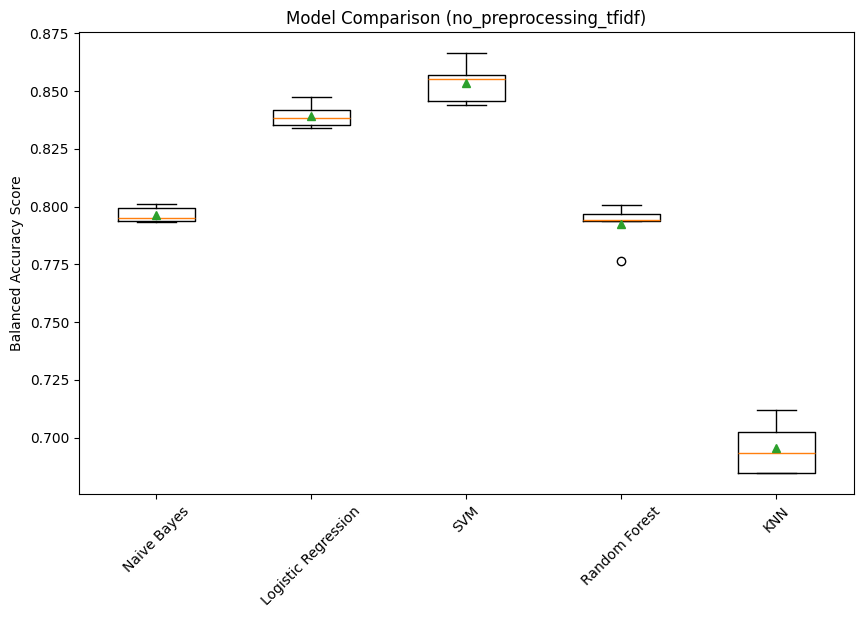

Results for preprocess_tfidf (TFIDF):


/tmp/ipykernel_141391/2226451576.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys(), showmeans=True)


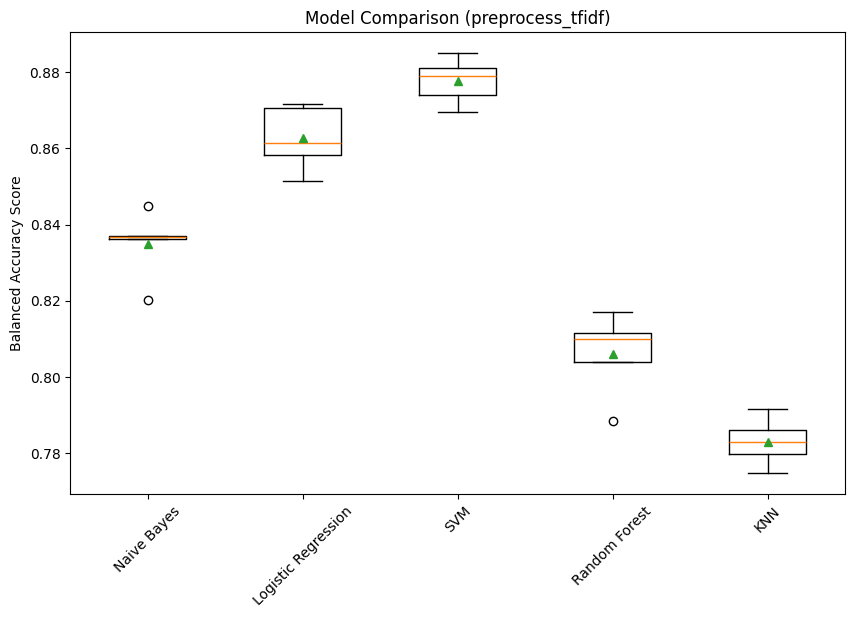

Results for augmentation_and_preprocessing_tfidf (TFIDF):


/tmp/ipykernel_141391/2226451576.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys(), showmeans=True)


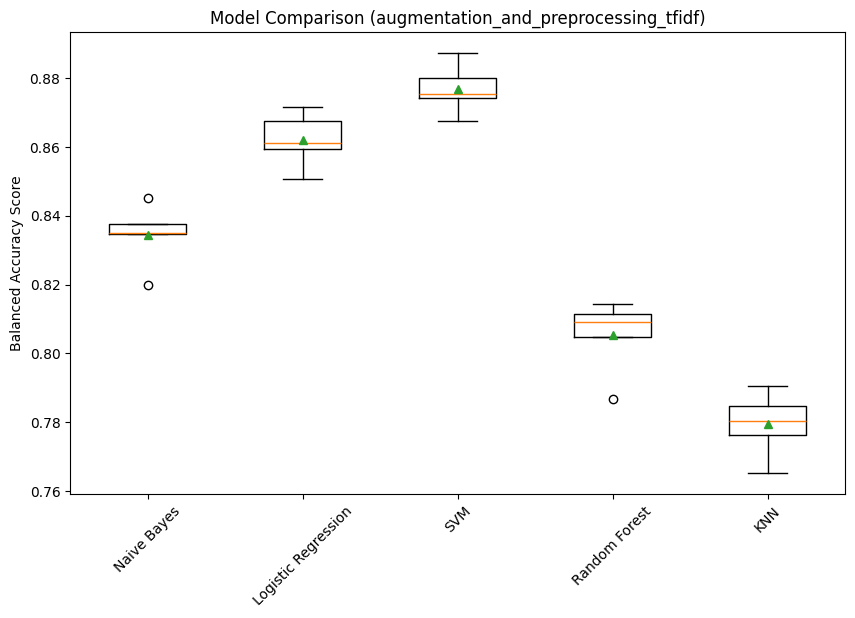

In [56]:
for preprocessing_tfidf, results_tfidf in results_per_preprocessing_tfidf.items():
    print(f"Results for {preprocessing_tfidf} (TFIDF):")
    plot_results(results_tfidf, preprocessing_tfidf)

Results for augmentation_and_preprocessing_bow (BOW):


/tmp/ipykernel_141391/2226451576.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys(), showmeans=True)


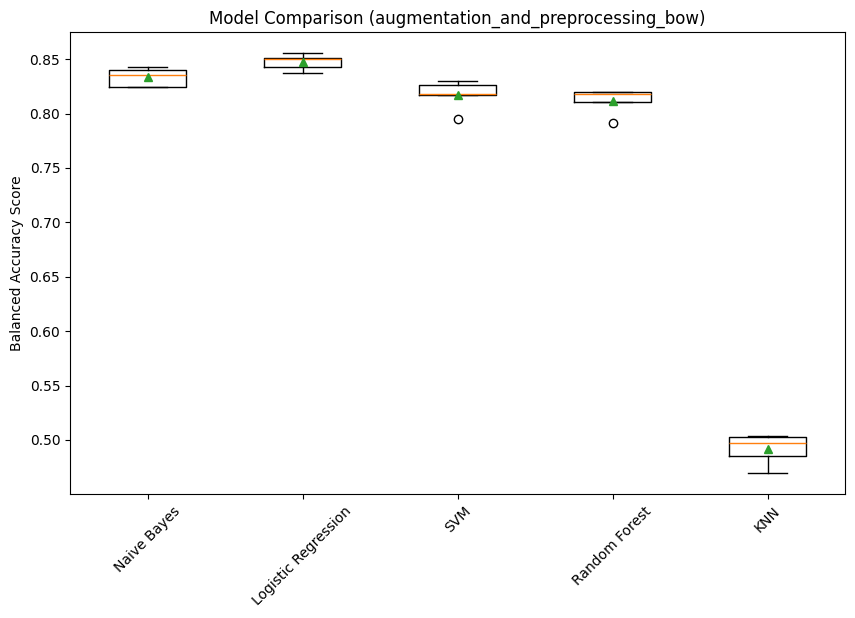

In [57]:
for preprocessing_bow, results_bow in results_per_preprocessing_bow.items():
    print(f"Results for {preprocessing_bow} (BOW):")
    plot_results(results_bow, preprocessing_bow)

In [58]:
best_model_name_tfidf = max(results_tfidf, key=lambda model: results_tfidf[model].mean())
print(f"The best model is: {best_model_name_tfidf}")

The best model is: SVM


In [59]:
best_model_name_bow = max(results_bow, key=lambda model: results_bow[model].mean())
print(f"The best model is: {best_model_name_bow}")

The best model is: Logistic Regression


In [60]:
best_model_pipeline = models[best_model_name_tfidf]

param_grids = {
    "SVM": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"],
        "clf__class_weight": [
            None,
            "balanced",
        ],
    }
}

if best_model_name_tfidf in param_grids:
    param_grid = param_grids[best_model_name_tfidf]
    best_model_pipeline = perform_grid_search(
        best_model_pipeline, param_grid, X_train_aug_preprocessed, y_train, is_balanced
    )

Best hyperparameters: {'clf__C': 10, 'clf__class_weight': None, 'clf__gamma': 'scale'}


In [69]:
grid_search_accuracy = accuracy_score(y_test, best_model_pipeline.predict(X_test_aug_preprocessed))
print(f"Grid search accuracy: {grid_search_accuracy:.4f}")

Grid search accuracy: 0.8798


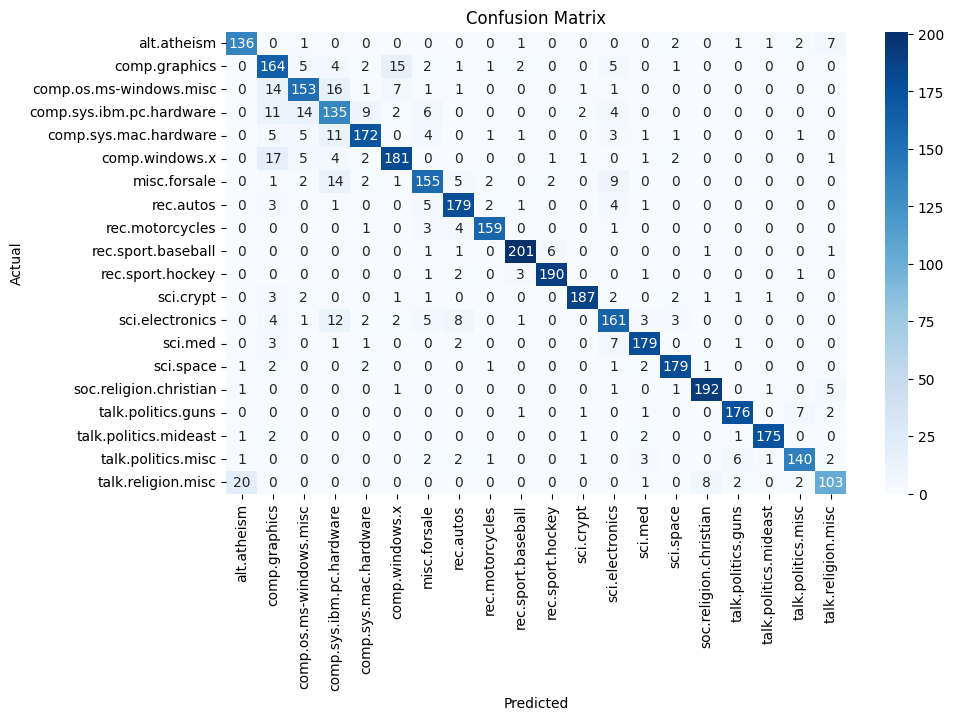

In [61]:
plot_confusion_matrix(best_model_pipeline, X_test_aug_preprocessed, y_test, class_names)

In [62]:
top_words = []

tfidf_vectorizer = best_model_pipeline.named_steps["tfidf"]
classifier = best_model_pipeline.named_steps["clf"]

print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")
print(f"Number of classes: {classifier.classes_.size}")

feature_names = tfidf_vectorizer.get_feature_names_out()
class_index = 0
coef = classifier.coef_[class_index].toarray().flatten()

top20_indices = coef.argsort()[-20:][::-1]
print("Top 20 important words:")
for idx in top20_indices:
    print(f"{feature_names[idx]}: {coef[idx]}")
    top_words.append(feature_names[idx])

Number of features: 5000
Number of classes: 20
Top 20 important words:
atheist: 1.7139269791395153
god: 1.5384937892870607
fish: 1.3817565050867828
altath: 1.3628563196568062
conner: 1.262956793280478
go hell: 1.1504208621812555
christian: 1.1448510701314736
peopl: 1.1257005881726112
atheism: 1.0994953114022137
moral: 1.0781757361224313
bibl: 1.0715296125663074
mathew: 1.0554932174306937
benedikt: 1.0431152479936234
keith: 1.0373631769413736
bill: 1.0344644020757587
islam: 1.0242617145032684
write: 1.0096658005559505
religion: 0.9675379204108995
hell: 0.9623676891501043
look: 0.943104502938468


Ratio: 0.1, Score: 0.7581
Ratio: 0.25, Score: 0.8072
Ratio: 0.5, Score: 0.8469
Ratio: 0.75, Score: 0.8714
Ratio: 1.0, Score: 0.8798


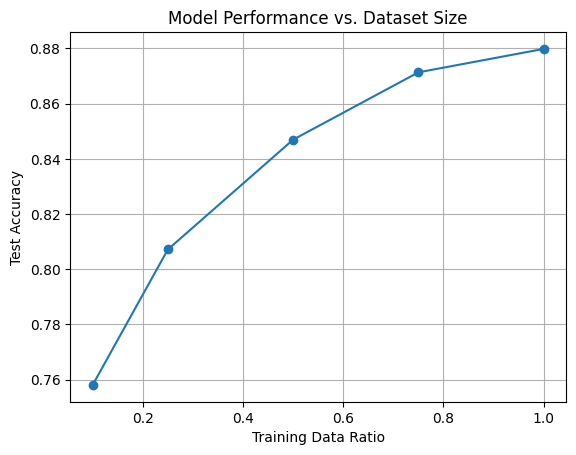

In [63]:
ratios, scores = downsample_and_evaluate(
    X_train_aug_preprocessed,
    y_train,
    X_test_aug_preprocessed,
    y_test,
    best_model_pipeline,
)

plt.plot(ratios, scores, marker="o")
plt.title("Model Performance vs. Dataset Size")
plt.xlabel("Training Data Ratio")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.savefig(f"{os.getcwd()}/model_performance_vs_dataset_size.png")
plt.show()

In [72]:
topic_assignments, lda_model = perform_topic_modeling_and_assign_topics(
    X_train_aug_preprocessed
)

In [73]:
topic_models = train_topic_based_classifiers(
    tfidf_vectorizer.transform(X_train_aug_preprocessed),
    y_train,
    topic_assignments,
    classifier,
)

In [74]:
predictions = classify_with_topic_model(
    X_test_aug_preprocessed, lda_model, topic_models, tfidf_vectorizer
)

Accuracy: 0.8610

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       151
           1       0.69      0.79      0.73       202
           2       0.79      0.76      0.77       195
           3       0.67      0.73      0.70       183
           4       0.83      0.82      0.83       205
           5       0.82      0.85      0.83       215
           6       0.88      0.76      0.82       193
           7       0.86      0.92      0.89       196
           8       0.89      0.94      0.92       168
           9       0.94      0.90      0.92       211
          10       0.97      0.93      0.95       198
          11       0.95      0.93      0.94       201
          12       0.80      0.75      0.78       202
          13       0.85      0.89      0.87       194
          14       0.92      0.94      0.93       189
          15       0.94      0.94      0.94       202
          16       0.92      0.93      0

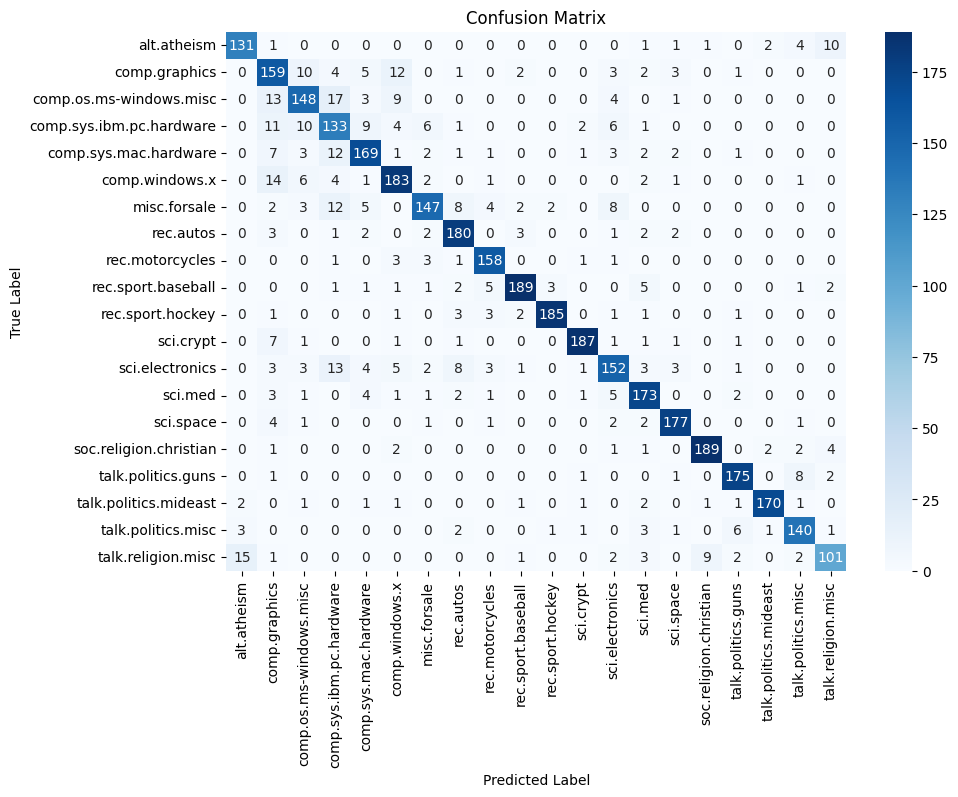

In [75]:
accuracy = accuracy_score(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig(f"{os.getcwd()}/confusion_matrix.png")
plt.show()